In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

2025-04-30 19:11:24.386047: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 19:11:24.556347: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746020484.620401   61879 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746020484.663823   61879 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746020484.792786   61879 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

def load_images_label_pairs(image_dir, label_dir, step=1, step_size=1000):
    image_files = sorted(os.listdir(image_dir))  # Sort to maintain consistency
    label_files = sorted(os.listdir(label_dir))

    images =[]
    labels=[]

    # currupted_images = [2355, 2365, 2366]
    print("Images count: " + str(len(image_files)))
    for img, label in zip(image_files[step * step_size: (step + 1) * step_size], label_files[step * step_size: (step + 1) * step_size]):
        print("Processing image: " + img)
        img_path = os.path.join(image_dir, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Adjust if images are colored
        images.append(img)


        label_path = os.path.join(label_dir, label)
        label = np.load(label_path)
        label = cv2.resize(label, (128, 128))  # Resize to match the image size
        labels.append(label)


    return np.array(images), np.array(labels)


# Print the shapes of the resulting datasets


In [3]:
# Dice Loss
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Learning Rate Scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Lightweight U-Net Model
def lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128)):
    # Input layer with flexible dimensions
    inputs = Input(input_size)
    
    # Preprocessing layers
    # Resizing layer
    x = tf.keras.layers.Resizing(target_size[0], target_size[1])(inputs)
    
    # Normalization layer (scales values to 0-1 range)
    x = tf.keras.layers.Rescaling(1./255)(x)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Bottleneck
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    
    # Decoder
    u4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    c4 = BatchNormalization()(c4)
    
    u5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(32, (3, 3), activation='relu', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)
    
    model = Model(inputs, outputs)
    
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy',  # You could also use your dice_loss here
                  metrics=['accuracy'])
    return model

In [4]:


gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6144)])  # 6GB in MB
    except RuntimeError as e:
        print(e)


# Create model with flexible input size
light_unet = lightweight_unet_model(input_size=(None, None, 1), target_size=(128, 128))
# light_unet.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(scheduler)

image_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/images'
label_dir_path = '/home/yasas/GazeEstimation/openEDS/openEDS/train/labels'


for i in range(1):
    images, labels = load_images_label_pairs(image_dir_path, label_dir_path, step=i, step_size=2200)
    labels = labels / np.max(labels)

    img_train, img_test, label_train, label_test = train_test_split(images, labels, test_size=0.2, random_state=42)
    total_iterations = 2
    images_per_iteration =  len(img_train) // total_iterations
    validation_size = len(img_test) // total_iterations

    print(f"Training images shape: {img_train.shape}")
    print(f"Training labels shape: {label_train.shape}")
    print(f"Testing images shape: {img_test.shape}")
    print(f"Testing labels shape: {label_test.shape}")

    history = light_unet.fit(
            img_train, label_train,
            validation_data=(img_test, label_test),
            epochs=50,
            batch_size=5,
            callbacks=[early_stopping, lr_scheduler],
            shuffle=True
        )
        
        
# Save the model
light_unet.save('light_weight_unet_gaze_estimation_model_2.h5')  # <-- Typo fixed


I0000 00:00:1746020511.051306   61879 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Images count: 27431
Processing image: 000000.png
Processing image: 000001.png
Processing image: 000002.png
Processing image: 000003.png
Processing image: 000004.png
Processing image: 000005.png
Processing image: 000006.png
Processing image: 000007.png
Processing image: 000008.png
Processing image: 000009.png
Processing image: 000010.png
Processing image: 000011.png
Processing image: 000012.png
Processing image: 000013.png
Processing image: 000014.png
Processing image: 000015.png
Processing image: 000016.png
Processing image: 000017.png
Processing image: 000018.png
Processing image: 000019.png
Processing image: 000020.png
Processing image: 000021.png
Processing image: 000022.png
Processing image: 000023.png
Processing image: 000024.png
Processing image: 000025.png
Processing image: 000026.png
Processing image: 000027.png
Processing image: 000028.png
Processing image: 000029.png
Processing image: 000030.png
Processing image: 000031.png
Processing image: 000032.png
Processing image: 00003

I0000 00:00:1746020534.990246   62008 service.cc:152] XLA service 0x7f9a740029a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746020534.990673   62008 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-04-30 19:12:15.099945: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746020535.641311   62008 cuda_dnn.cc:529] Loaded cuDNN version 90300


  6/352 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.4903 - loss: 0.7960

I0000 00:00:1746020540.616919   62008 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


352/352 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - accuracy: 0.7934 - loss: 0.4089 - val_accuracy: 0.8536 - val_loss: 0.2856 - learning_rate: 0.0010
Epoch 2/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8596 - loss: 0.1135 - val_accuracy: 0.8598 - val_loss: 0.1138 - learning_rate: 0.0010
Epoch 3/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8574 - loss: 0.1024 - val_accuracy: 0.8604 - val_loss: 0.0995 - learning_rate: 0.0010
Epoch 4/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8588 - loss: 0.0978 - val_accuracy: 0.8603 - val_loss: 0.0946 - learning_rate: 0.0010
Epoch 5/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8568 - loss: 0.0966 - val_accuracy: 0.8602 - val_loss: 0.0970 - learning_rate: 0.0010
Epoch 6/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8583 - loss: 0.0953 - val_accuracy: 0.8602 - val_loss: 0.0932 - learning_rate: 0.0010
Epoch 7/50
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.8598 - loss: 0.0933 - val

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step
(128, 128)


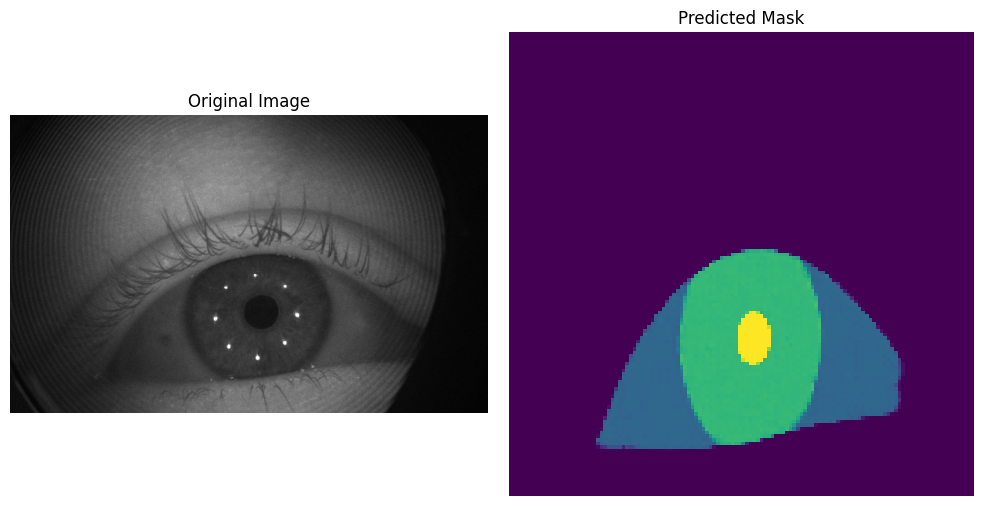

In [7]:
# Re-define dice_loss again (important!)
def dice_loss(y_true, y_pred):
    smooth = 1.0
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

# Now load the model properly
model = load_model('light_weight_unet_gaze_estimation_model_2.h5', custom_objects={'dice_loss': dice_loss})

# Define the path to the image you want to predict
image_path = '/home/yasas/GazeEstimation/openEDS/openEDS/S_12/15.png'  # Assuming grayscale image

# Load the image using OpenCV
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# No need to resize or normalize manually since these operations are part of the model
# Simply prepare the input with proper dimensions
int_image = np.expand_dims(image, axis=0)  # Add batch dimension: (1, height, width)
input_image = np.expand_dims(int_image, axis=-1)  # Add channel dimension: (1, height, width, 1)

# Predict the output using the model
predicted_mask = model.predict(input_image)

# Remove batch dimension to get the mask image
predicted_mask = predicted_mask[0, :, :, 0]  # Shape: (height, width)

# Save original image dimensions for display
original_shape = image.shape
# Display the original image and the predicted mask side by side

print(predicted_mask.shape)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask)
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: If you need to save the mask
# cv2.imwrite('predicted_mask.png', (predicted_mask * 255).astype(np.uint8))

In [ ]:
# Load the model with the custom dice_loss function
model = tf.keras.models.load_model(
	'light_weight_unet_gaze_estimation_model_2.h5',
	custom_objects={'dice_loss': dice_loss}
)

# Save the model in the SavedModel format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('light_weight_unet_gaze_estimation_model_2.tflite', 'wb') as f:
    f.write(tflite_model)

TypeError: this __dict__ descriptor does not support '_DictWrapper' objects